In [1]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVC  # support vector machines classification
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier # neural network for classification
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # adaboost for classification
import xgboost as xgb
# saving models
# from sklearn.externals import joblib
import joblib
import matplotlib.pyplot as plt



In [2]:
import pandas as pd
import random
import math

# read in time point 1 for training
# train on it - model 1
# test on tp 2
# read tp 2
# add it to xgb - model 2
# test on tp 3
# read tp 3
# add it to xgb - model 3
# test on tp 4
# test model 1
data = pd.read_csv('data_no_2022_synthesized_nonstationary.csv')
data.head()

,yield,radiation,rain,avg_min_temp,avg_max_temp,class
0,0.830223,372436.113946,3830.601559,3.166761,14.233006,0
1,0.768636,373381.000000,3837.770000,3.190400,14.261800,0
2,0.618846,262881.280000,2719.270000,3.706600,14.770500,0
3,0.766452,48010.950000,301.990000,12.436900,25.583800,0
4,0.583333,375856.040000,4160.070000,3.700100,14.655400,0


In [3]:
print(len(data))

20255


In [4]:
data = data.rename(columns={'Yield (tons/acre)':'yield'})

In [5]:
xColumnsToKeep = ["radiation","rain", "avg_max_temp", "avg_min_temp"]

# the target to keep
yColumnsToKeep = ["yield"]

# get a dataframe containing the features and the targets
xDf = data[xColumnsToKeep]


yDf = data[yColumnsToKeep]


In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error


In [7]:
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile

In [38]:
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
import numpy as np

# Define the number of features to select (e.g., you can set it as an integer or a percentage)
features = 4  # Example: Select top 3 features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xDf, yDf, test_size=0.2, random_state=42)

# Extract the first column from y_test and flatten it
y_test_flat = y_test.iloc[:, 0].values  # Use .iloc to select the first column and convert to 1D array

# Standardization
standardScaler = preprocessing.StandardScaler()

# Feature Selection
if type(features) == int:
    featureSelection = SelectKBest(f_regression, k=features)
elif type(features) == float:
    featuresPercentile = features / 100.0
    featureSelection = SelectPercentile(f_regression, percentile=featuresPercentile)
else:
    raise ValueError("The input 'features' is not an integer or a float. It should be.")

# Define the pipeline with standardization, feature selection, and the model
pipe = Pipeline(steps=[
    ('standardization', standardScaler),
    ('feature selection', featureSelection),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'))
])

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    # Update the pipeline model with the hyperparameters from Optuna trial
    pipe.set_params(model__n_estimators=param['n_estimators'],
                    model__max_depth=param['max_depth'],
                    model__learning_rate=param['learning_rate'],
                    model__subsample=param['subsample'],
                    model__colsample_bytree=param['colsample_bytree'],
                    model__gamma=param['gamma'],
                    model__min_child_weight=param['min_child_weight'],
                    model__reg_alpha=param['reg_alpha'],
                    model__reg_lambda=param['reg_lambda'])

    # Train the model on the training data
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)
    
    # Evaluation metrics
    mae = mean_absolute_error(y_test_flat, y_pred)
    r2 = r2_score(y_test_flat, y_pred)
    
    # Pearson's Correlation Coefficient (R)
    correlation_matrix = np.corrcoef(y_test_flat, y_pred)
    correlation = correlation_matrix[0, 1]
    
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    def smape(y_true, y_pred):
        denominator = np.abs(y_true) + np.abs(y_pred)
        diff = np.abs(y_true - y_pred) / denominator
        diff[denominator == 0] = 0.0  # Handle the case where both true and predicted values are zero
        return 100 * np.mean(diff)
    
    smape_value = smape(y_test_flat, y_pred)
    
    # Composite objective: maximize R² and correlation, minimize MAE and SMAPE
    # We subtract MAE and SMAPE to minimize them and add R² and correlation to maximize them
    
    
    # Return the objective value to Optuna
    return mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')  # Maximize the combined objective
study.optimize(objective, n_trials=100)  # Perform 100 trials

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final model with the best hyperparameters
pipe.set_params(model__n_estimators=best_params['n_estimators'],
                model__max_depth=best_params['max_depth'],
                model__learning_rate=best_params['learning_rate'],
                model__subsample=best_params['subsample'],
                model__colsample_bytree=best_params['colsample_bytree'],
                model__gamma=best_params['gamma'],
                model__min_child_weight=best_params['min_child_weight'],
                model__reg_alpha=best_params['reg_alpha'],
                model__reg_lambda=best_params['reg_lambda'])

pipe.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = pipe.predict(X_test)

# Print evaluation metrics
mae = mean_absolute_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)
correlation_matrix = np.corrcoef(y_test_flat, y_pred)
correlation = correlation_matrix[0, 1]
smape_value = smape(y_test_flat, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² (Coefficient of Determination): {r2}')
print(f'Pearson\'s Correlation Coefficient (R): {correlation}')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}')


[I 2025-04-05 14:36:59,389] A new study created in memory with name: no-name-e4cb3dd9-0c10-487f-a581-0d3d93e0e469
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-04-05 14:36:59,547] Trial 0 finished with value: 0.30372037185819917 and parameters: {'n_estimators': 56, 'max_depth': 8, 'learning_rate': 0.07521138661743881, 'subsample': 0.7022008861176435, 'colsample_bytree': 0.5057478289755242, 'gamma': 0.253348716374735, 'min_child_weight': 4, 'reg_alpha': 0.32885742419495323, 'reg_lambda': 0.1932518256011374}. Best is trial 0 with value: 0.30372037185819917.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 

Best hyperparameters: {'n_estimators': 265, 'max_depth': 7, 'learning_rate': 0.028388823983877952, 'subsample': 0.9675062141282212, 'colsample_bytree': 0.8045529553286656, 'gamma': 0.022027752698445285, 'min_child_weight': 3, 'reg_alpha': 0.3800290592594657, 'reg_lambda': 0.34350965513648196}
Mean Absolute Error (MAE): 0.2859586213396137
R² (Coefficient of Determination): 0.5964543680416388
Pearson's Correlation Coefficient (R): 0.7724245907600605
Symmetric Mean Absolute Percentage Error (SMAPE): 8.551990902434076


In [14]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the number of features to select (e.g., you can set it as an integer or a percentage)
features = 4  # Example: Select top 3 features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xDf, yDf, test_size=0.2, random_state=42)

# Extract the first column from y_test and flatten it
y_test_flat = y_test.iloc[:, 0].values  # Use .iloc to select the first column and convert to 1D array

# Standardization
standardScaler = preprocessing.StandardScaler()

# Feature Selection
if type(features) == int:
    featureSelection = SelectKBest(f_regression, k=features)
elif type(features) == float:
    featuresPercentile = features / 100.0
    featureSelection = SelectPercentile(f_regression, percentile=featuresPercentile)
else:
    raise ValueError("The input 'features' is not an integer or a float. It should be.")

# Define the pipeline with standardization, feature selection, and the model
pipe = Pipeline(steps=[
    ('standardization', standardScaler),
    ('feature selection', featureSelection),
    ('model', RandomForestRegressor(random_state=42))
])

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space for RandomForestRegressor
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    # Update the pipeline model with the hyperparameters from Optuna trial
    pipe.set_params(model__n_estimators=param['n_estimators'],
                    model__max_depth=param['max_depth'],
                    model__min_samples_split=param['min_samples_split'],
                    model__min_samples_leaf=param['min_samples_leaf'],
                    model__max_features=param['max_features'],
                    model__bootstrap=param['bootstrap'])

    # Train the model on the training data
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)
    
    # Evaluation metrics
    mae = mean_absolute_error(y_test_flat, y_pred)
    r2 = r2_score(y_test_flat, y_pred)
    
    # Pearson's Correlation Coefficient (R)
    correlation_matrix = np.corrcoef(y_test_flat, y_pred)
    correlation = correlation_matrix[0, 1]
    
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    def smape(y_true, y_pred):
        denominator = np.abs(y_true) + np.abs(y_pred)
        diff = np.abs(y_true - y_pred) / denominator
        diff[denominator == 0] = 0.0  # Handle the case where both true and predicted values are zero
        return 100 * np.mean(diff)
    
    smape_value = smape(y_test_flat, y_pred)
    
    # Composite objective: minimize MAE and SMAPE, maximize R² and correlation
    return mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')  # Minimize the objective
study.optimize(objective, n_trials=100)  # Perform 100 trials

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final model with the best hyperparameters
pipe.set_params(model__n_estimators=best_params['n_estimators'],
                model__max_depth=best_params['max_depth'],
                model__min_samples_split=best_params['min_samples_split'],
                model__min_samples_leaf=best_params['min_samples_leaf'],
                model__max_features=best_params['max_features'],
                model__bootstrap=best_params['bootstrap'])

pipe.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = pipe.predict(X_test)

# Print evaluation metrics
mae = mean_absolute_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)
correlation_matrix = np.corrcoef(y_test_flat, y_pred)
correlation = correlation_matrix[0, 1]
smape_value = smape(y_test_flat, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² (Coefficient of Determination): {r2}')
print(f'Pearson\'s Correlation Coefficient (R): {correlation}')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}')


[I 2025-04-06 21:42:52,192] A new study created in memory with name: no-name-ad58dd38-2c27-4fb0-9599-563ed1e84a6e
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-04-06 21:42:55,710] Trial 0 finished with value: 0.2825224324485484 and parameters: {'n_estimators': 244, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.2825224324485484.
/Library/

Best hyperparameters: {'n_estimators': 246, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}


NameError: name 'smape' is not defined

In [15]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the number of features to select (e.g., you can set it as an integer or a percentage)
features = 4  # Example: Select top 4 features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xDf, yDf, test_size=0.2, random_state=42)

# Extract the first column from y_test and flatten it
y_test_flat = y_test.iloc[:, 0].values  # Use .iloc to select the first column and convert to 1D array

# Standardization
standardScaler = preprocessing.StandardScaler()

# Feature Selection
if type(features) == int:
    featureSelection = SelectKBest(f_regression, k=features)
elif type(features) == float:
    featuresPercentile = features / 100.0
    featureSelection = SelectPercentile(f_regression, percentile=featuresPercentile)
else:
    raise ValueError("The input 'features' is not an integer or a float. It should be.")

# Define the pipeline with standardization, feature selection, and the model
pipe = Pipeline(steps=[
    ('standardization', standardScaler),
    ('feature selection', featureSelection),
    ('model', RandomForestRegressor(random_state=42))
])

# Define the SMAPE function for reusability
def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # Handle the case where both true and predicted values are zero
    return 100 * np.mean(diff)

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space for RandomForestRegressor
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    # Update the pipeline model with the hyperparameters from Optuna trial
    pipe.set_params(model__n_estimators=param['n_estimators'],
                    model__max_depth=param['max_depth'],
                    model__min_samples_split=param['min_samples_split'],
                    model__min_samples_leaf=param['min_samples_leaf'],
                    model__max_features=param['max_features'],
                    model__bootstrap=param['bootstrap'])

    # Train the model on the training data
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)
    
    # Evaluation metrics
    mae = mean_absolute_error(y_test_flat, y_pred)
    r2 = r2_score(y_test_flat, y_pred)
    
    # Pearson's Correlation Coefficient (R)
    correlation_matrix = np.corrcoef(y_test_flat, y_pred)
    correlation = correlation_matrix[0, 1]
    
    smape_value = smape(y_test_flat, y_pred)
    
    # Composite objective: minimize MAE and SMAPE, maximize R² and correlation
    return mae  # Minimize MAE

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')  # Minimize the objective
study.optimize(objective, n_trials=100)  # Perform 100 trials

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final model with the best hyperparameters
pipe.set_params(model__n_estimators=best_params['n_estimators'],
                model__max_depth=best_params['max_depth'],
                model__min_samples_split=best_params['min_samples_split'],
                model__min_samples_leaf=best_params['min_samples_leaf'],
                model__max_features=best_params['max_features'],
                model__bootstrap=best_params['bootstrap'])

pipe.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = pipe.predict(X_test)

# Print evaluation metrics
mae = mean_absolute_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)
correlation_matrix = np.corrcoef(y_test_flat, y_pred)
correlation = correlation_matrix[0, 1]
smape_value = smape(y_test_flat, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² (Coefficient of Determination): {r2}')
print(f'Pearson\'s Correlation Coefficient (R): {correlation}')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}')


[I 2025-04-06 22:06:04,844] A new study created in memory with name: no-name-dbe95f4d-bf6f-4030-83ee-f82ad3cdd608
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-04-06 22:06:08,985] Trial 0 finished with value: 0.2765092348232711 and parameters: {'n_estimators': 132, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.2765092348232711.
/Librar

Best hyperparameters: {'n_estimators': 211, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Mean Absolute Error (MAE): 0.276226313542165
R² (Coefficient of Determination): 0.6138893499628557
Pearson's Correlation Coefficient (R): 0.7836634246671279
Symmetric Mean Absolute Percentage Error (SMAPE): 8.113925713737258


In [39]:
target_yearDf=pd.read_csv('target_yearDf.csv')

In [40]:
print(len(target_yearDf))

17


In [41]:
xColumnsToKeep = ["radiation","rain", "avg_max_temp", "avg_min_temp"]

# the target to keep
yColumnsToKeep = ["yield"]

# get a dataframe containing the features and the targets
target_xDf = target_yearDf[xColumnsToKeep]


target_yDf = target_yearDf[yColumnsToKeep]

Test Data (x): 
       radiation         rain  avg_max_temp  avg_min_temp
0  364594.600933  3632.751078     15.137881      4.007950
1  179717.565881  1897.780611     15.392265      4.179943
2  228708.551394  2269.272999     14.753561      3.580661
3  207395.006093  2124.276276     13.720995      2.748824
4  344873.818524  3477.966090     14.582746      3.546103
Test Data (y): 
      yield
0  0.910029
1  1.125202
2  1.114043
3  1.138770
4  1.369327
Train Data (x): 
       radiation         rain  avg_max_temp  avg_min_temp
0  364594.600933  3632.751078     15.137881      4.007950
1  179717.565881  1897.780611     15.392265      4.179943
2  228708.551394  2269.272999     14.753561      3.580661
3  207395.006093  2124.276276     13.720995      2.748824
4  344873.818524  3477.966090     14.582746      3.546103
Train Data (y): 
      yield
0  0.910029
1  1.125202
2  1.114043
3  1.138770
4  1.369327

Performance Metrics:
Avg MAE: 0.6650116443634033
Avg R squared: -7.0263872146606445
R Score (

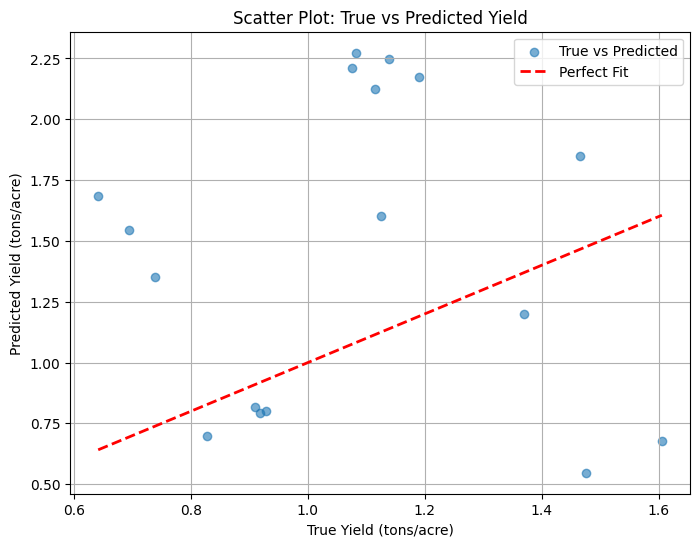

In [11]:
# Print values in the specified format
#print(f"Model: {aModelList[0][2]}")  # Model name
print(f"Test Data (x): \n{target_xDf.head()}")  # Test features
print(f"Test Data (y): \n{target_yDf.head()}")  # Test targets
#print(f"N: {N}")  # Number of iterations
print(f"Train Data (x): \n{target_xDf.head()}")  # Training features
print(f"Train Data (y): \n{target_yDf.head()}")  # Training targets
#print(f"Working Directory: {workingDir}")
#print(f"Number of Features: {numFeatures}")

# Assuming 'xgbModel' is trained earlier in the pipeline
#xgb_model = xgb.XGBRegressor()
#xgb_model.fit(target_xDf, target_yDf.values.ravel())  # Fit model with training data
y_pred = pipe.predict(target_xDf)  # Predict on test data

# Compute metrics
mae = mean_absolute_error(target_yDf, y_pred)
r_squared = r2_score(target_yDf, y_pred)
r_score = np.corrcoef(target_yDf.values.flatten(), y_pred)[0, 1]


print("\nPerformance Metrics:")
print(f"Avg MAE: {mae}")
print(f"Avg R squared: {r_squared}")

print(f"R Score (Correlation): {r_score:.4f}")

# Scatter plot of true yield vs predicted yield
plt.figure(figsize=(8, 6))
plt.scatter(target_yDf, y_pred, alpha=0.6, label="True vs Predicted")
plt.plot([target_yDf.min(), target_yDf.max()], [target_yDf.min(), target_yDf.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("True Yield (tons/acre)")
plt.ylabel("Predicted Yield (tons/acre)")
plt.title("Scatter Plot: True vs Predicted Yield")
plt.legend()
plt.grid()
plt.show()


In [42]:
all_yearsDf=pd.read_csv("all_years.csv")

0.6294454813898634
R:  0.0025707847820718166
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.067
Method:                 Least Squares   F-statistic:                 9.913e-05
Date:                Sat, 05 Apr 2025   Prob (F-statistic):              0.992
Time:                        14:40:59   Log-Likelihood:                -2.1605
No. Observations:                  17   AIC:                             8.321
Df Residuals:                      15   BIC:                             9.987
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_

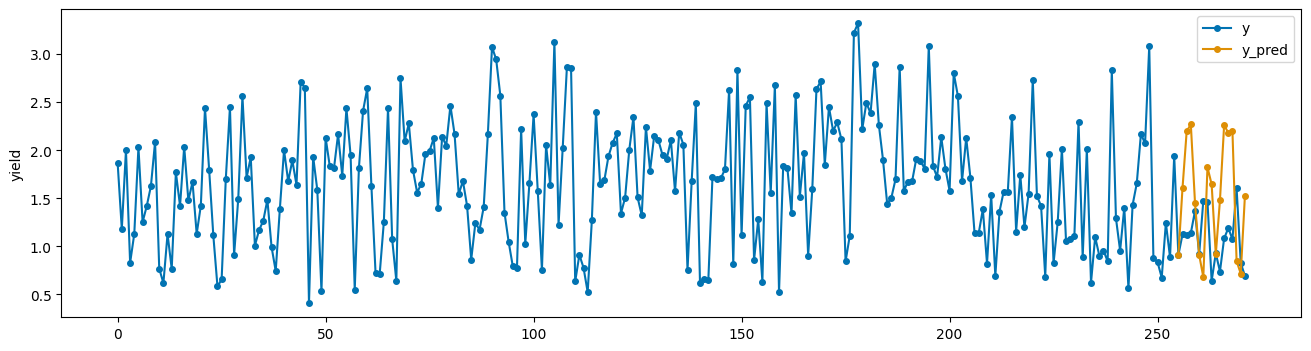

In [47]:
m1,r2=actualTest(all_yearsDf, target_yearDf, target_xDf, target_yDf, pipe)

In [46]:
def actualTest(all_yearsDf, target_yearDf, xTest, yTest, model):
    #print("Length of all_yearsDf----This is used for plotting graph ", len(all_yearsDf))
    #print("Length of final_yearDf-----This is used for adjusting the predicted values: ", len(final_yearDf))
    #print("Length of target_yearDf-------This is used for comparing predicted values to true values-----these are true values ", len(target_yearDf))
    #print("boost_xDf: ",len(boost_xDf))
    #print("boost_yDf: ", len(boost_yDf))
    #print("Length of xTest: ", len(xTest))
    #print("Length of yTest: ", len(yTest))
    #print("test results on our test data: ")
    #print(yTest)
    
    #model = model.fit(boost_xDf, boost_yDf, xgb_model=model.get_booster())
    # get predictions
    pred = model.predict(xTest)
    #trainPred = model.predict(xTrain)
    #print("Length of predictions are: ", len(pred))

    #adj_pred = []
    #for i in range(len(pred)):
    #    adj_pred.append(final_yearDf['yield'][i] + pred[i])
    #print('adjusted predictions: ')
    #print(adj_pred)
    #print("Predictions are: ")
    #print(pred)
    #print("Length of adjusted predictions: ", len(adj_pred))
    pred_Df = pd.DataFrame(pred)
    #print(adj_pred_Df)
    #adj_pred_Df=pd.DataFrame(pred)
    # find errors
    meanAbsoluteError = mean_absolute_error(target_yearDf['yield'], pred_Df)
    print(meanAbsoluteError)
#     plt.scatter(yTest, pred, label='Truth vs Prediction')
#     p1 = max(max(pred), max(yTest['Yield (tons/acre)']))
#     p2 = min(min(pred), min(yTest['Yield (tons/acre)']))
#     plt.plot([p1, p2], [p1, p2], color='k', label='Perfect Predictions')
#     plt.xlabel('True Yields')
#     plt.ylabel('Predicted Yields')
#     plt.legend()
    #print("Plotting--------")
    pred_ts = []
    len_tsDf = len(all_yearsDf)
    #print("len_tsDf----Length of all_yearsDf----", len_tsDf)
    for i in range(len_tsDf - len(pred), len_tsDf):
        pred_ts.append(i)
    #print("Length of pred_ts is: ", len(pred_ts))
    #print("This is the index calculated for plotting time-series graph: ", pred_ts)    
    pred_df = pd.DataFrame(pred, index = pred_ts, columns = ['yield'])
    #print("Lengths of all_yearsDf and Lengths of pred_Df are: ", len(all_yearsDf['yield']), len(pred_df))
    #print("Head and shape of pred_Df")
    #print(pred_df.head())  # Check structure
    #print(pred_df.shape)   # Compare with all_yearsDf
    #print(all_yearsDf.index)
    plot_series(pd.Series(all_yearsDf['yield']), pred_df, labels=["y", "y_pred"])


    #plt.figure(figsize=(10, 6))

    # Plot actual yield using its index
    #plt.plot(all_yearsDf.index, all_yearsDf['yield'], label="Actual Yield", linestyle="-", color="blue")

    # Plot predicted yield using its index (from pred_df)
    #plt.plot(pred_df.index, pred_df['yield'], label="Predicted Yield", linestyle="--", color="red")

    #plt.xlabel("Index")  # The x-axis will now be the index of each DataFrame
    #plt.ylabel("Yield")
    #plt.legend()
    #plt.title("Actual vs. Predicted Yield")
    #plt.show()

    # find the R values
    r = np.corrcoef(target_yearDf['yield'], pred)[0,1]
    print("R: ",r)
    # find the R^2 coefficient of determination
    # defining the variables
#     r2x = xTest.tolist()
#     r2y = yTest.tolist()

    # adding the constant term
    r2pred = sm.add_constant(pred)

    # performing the regression
    # and fitting the model
    yTargetYield = target_yearDf['yield']
    result = sm.OLS(yTargetYield, r2pred).fit()

    # printing the summary table
    print(result.summary())
    print('skt mape: ' + str(round(skt_mape(yTargetYield, pred_Df) * 100, 3)) + '%')
    print('skt smape: ' + str(round(skt_smape(yTargetYield, pred_Df) * 100, 3)) + '%')
    print('skt mae: ' + str(round(skt_mae(yTargetYield, pred_Df), 3)))
    print('skt mse: ' + str(round(skt_mse(yTargetYield, pred_Df), 3)))
    print('skt rmse: ' + str(round(math.sqrt(skt_mse(yTargetYield, pred_Df)), 3)) + '\n\n')
    
    #accuracy = accuracy_score(yTest, pred)
    
    return(meanAbsoluteError, r)
    

#     # add the errors and R Squared to average values
#     avgMAE += meanAbsoluteError
#     avgRSq += rSq

#     # check to see which metric should be optimized
#     if metricToOptimize == 'r2':
#         # check to see if any of these are the best values
#         if (rSq > bestRSq):
#             bestMAE = meanAbsoluteError
#             bestModel = model
#             bestRSq = rSq

#     elif metricToOptimize == 'mae':
#         # check to see if any of these are the best values
#         if (meanAbsoluteError < bestMAE):
#             bestMAE = meanAbsoluteError
#             bestModel = model
#             bestRSq = rSq

#     else:
#         raise ValueError("The input 'metricToOptimize' does not have a valid input. It must be 'r2' or 'mae'.")

In [13]:
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import joblib
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import math

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sktime.utils.plotting import plot_series

# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, matthews_corrcoef
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVR  # support vector machines regression
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import AdaBoostRegressor # adaboost for regression
import xgboost as xgb

skt_mape = MeanAbsolutePercentageError(symmetric=False)
skt_smape = MeanAbsolutePercentageError(symmetric=True)
skt_mae = MeanAbsoluteError()
skt_mse = MeanSquaredError()

In [14]:
all_yearsDf_Chazy=pd.read_csv("all_years_Chazy.csv")

In [48]:
all_yearsDf_Cobleskill=pd.read_csv("all_years_Cobleskill.csv")

In [49]:
all_yearsDf_LeRoy=pd.read_csv("all_years_LeRoy.csv")

In [50]:
all_yearsDf_Perry=pd.read_csv("all_years_Perry.csv")

In [16]:
print(all_yearsDf_Chazy.head())

      yield  radiation     rain  avg_min_temp  avg_max_temp  class
0  1.194400  130742.75  1213.91        3.4019       14.2146      1
1  0.809200  145274.02  1297.63        4.4011       15.2895      0
2  1.324444   41061.00   336.42       13.7771       25.2588      1
3  1.771111   26518.36   252.70       12.9497       24.3164      1
4  1.426800  115786.58  1009.08        2.0242       12.7900      1


MAE:  0.4819318461350125
R value is:  0.04038841995901182
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                   0.02941
Date:                Sat, 05 Apr 2025   Prob (F-statistic):              0.866
Time:                        15:48:31   Log-Likelihood:                -13.252
No. Observations:                  20   AIC:                             30.50
Df Residuals:                      18   BIC:                             32.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/s

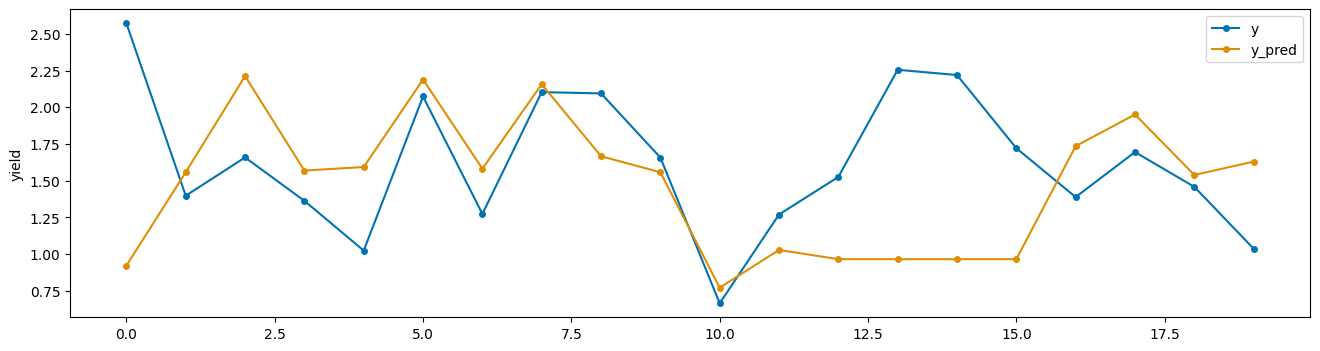

In [56]:
mae,r=actualTest_nonlocal(all_yearsDf_Perry,pipe)
print(mae)
print(r)

MAE:  0.5010632056760406
R value is:  0.5296925822290038
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     3.900
Date:                Sat, 05 Apr 2025   Prob (F-statistic):             0.0765
Time:                        15:46:25   Log-Likelihood:                -9.9454
No. Observations:                  12   AIC:                             23.89
Df Residuals:                      10   BIC:                             24.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_

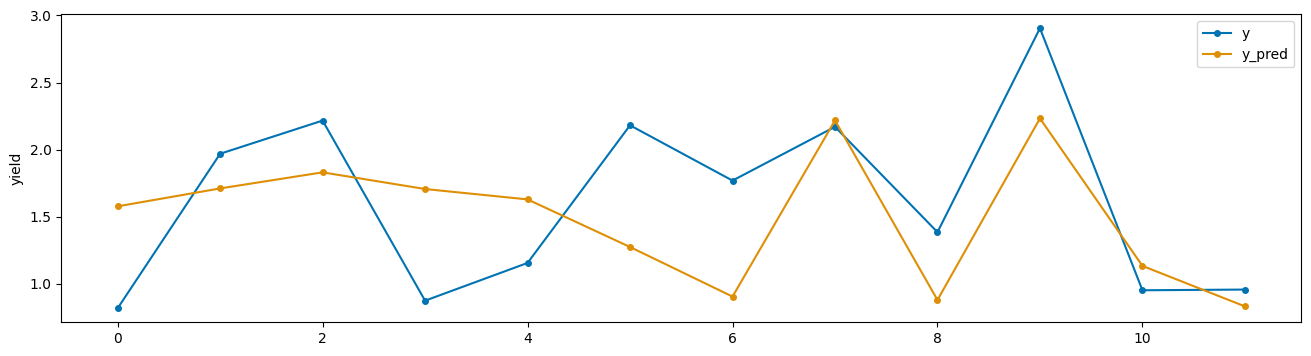

In [55]:
mae,r=actualTest_nonlocal(all_yearsDf_LeRoy,pipe)
print(mae)
print(r)

MAE:  0.6128995463553785
R value is:  0.18923353160051462
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.006
Date:                Sat, 05 Apr 2025   Prob (F-statistic):              0.162
Time:                        15:43:38   Log-Likelihood:                -43.583
No. Observations:                  56   AIC:                             91.17
Df Residuals:                      54   BIC:                             95.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/s

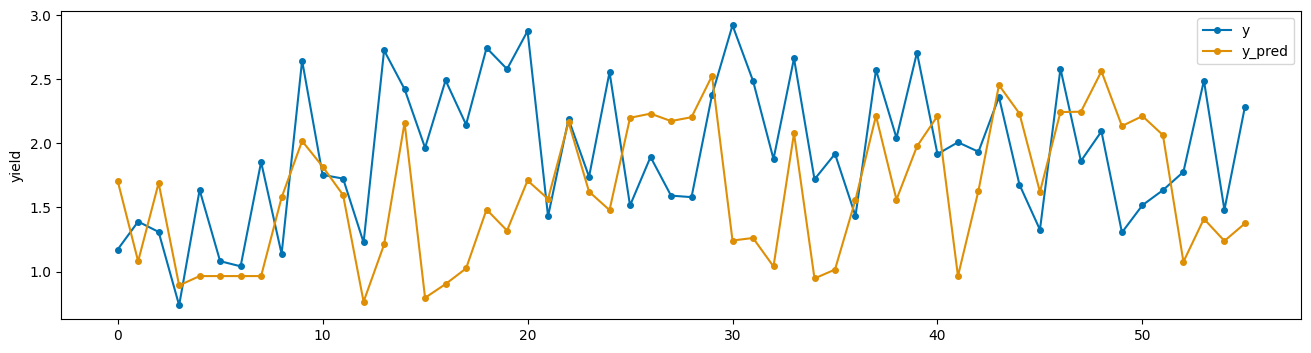

In [54]:
mae,r=actualTest_nonlocal(all_yearsDf_Cobleskill,pipe)
print(mae)
print(r)

MAE:  0.6458116927018307
R value is:  -0.07791374940618094
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.3237
Date:                Sat, 05 Apr 2025   Prob (F-statistic):              0.572
Time:                        15:42:54   Log-Likelihood:                -45.383
No. Observations:                  55   AIC:                             94.77
Df Residuals:                      53   BIC:                             98.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/s

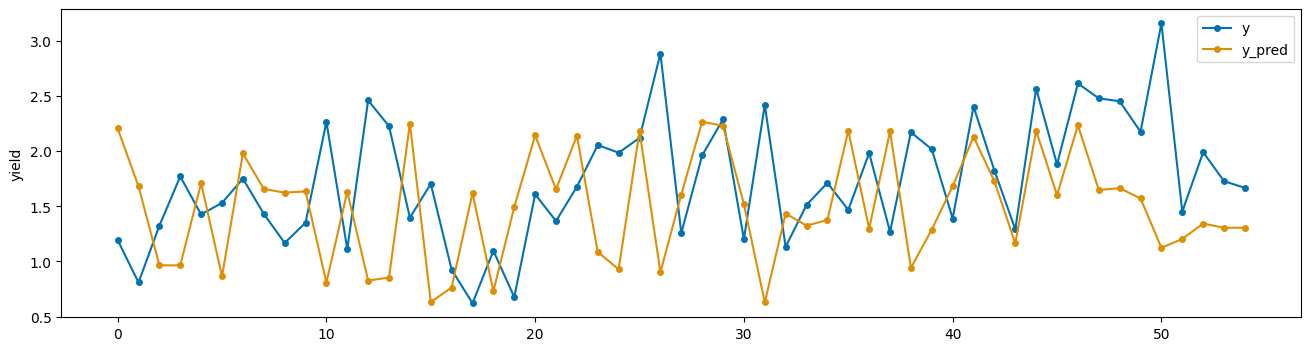

In [53]:
m1,r2=actualTest_nonlocal(all_yearsDf_Chazy, pipe)

In [52]:
def actualTest_nonlocal(all_yearsDf_Chazy, model):
    #print("Length of all_yearsDf----This is used for plotting graph ", len(all_yearsDf))
    #print("Length of final_yearDf-----This is used for adjusting the predicted values: ", len(final_yearDf))
    #print("Length of target_yearDf-------This is used for comparing predicted values to true values-----these are true values ", len(target_yearDf))
    #print("boost_xDf: ",len(boost_xDf))
    #print("boost_yDf: ", len(boost_yDf))
    #print("Length of xTest: ", len(xTest))
    #print("Length of yTest: ", len(yTest))
    #print("test results on our test data: ")
    #print(yTest)
    xTest = all_yearsDf_Chazy[["radiation", "rain", "avg_max_temp", "avg_min_temp"]]
    yTest=all_yearsDf_Chazy[["yield"]]
    #model = model.fit(boost_xDf, boost_yDf, xgb_model=model.get_booster())
    # get predictions
    pred = model.predict(xTest)
    #trainPred = model.predict(xTrain)
    #print("Length of predictions are: ", len(pred))

    #adj_pred = []
    #for i in range(len(pred)):
    #    adj_pred.append(final_yearDf['yield'][i] + pred[i])
    #print('adjusted predictions: ')
    #print(adj_pred)
    #print("Predictions are: ")
    #print(pred)
    #print("Length of adjusted predictions: ", len(adj_pred))
    pred_Df = pd.DataFrame(pred)
    #print(adj_pred_Df)
    #adj_pred_Df=pd.DataFrame(pred)
    # find errors
    meanAbsoluteError = mean_absolute_error(yTest, pred_Df)
    print("MAE: ", meanAbsoluteError)
#     plt.scatter(yTest, pred, label='Truth vs Prediction')
#     p1 = max(max(pred), max(yTest['Yield (tons/acre)']))
#     p2 = min(min(pred), min(yTest['Yield (tons/acre)']))
#     plt.plot([p1, p2], [p1, p2], color='k', label='Perfect Predictions')
#     plt.xlabel('True Yields')
#     plt.ylabel('Predicted Yields')
#     plt.legend()
    #print("Plotting--------")
    pred_ts = []
    len_tsDf = len(all_yearsDf_Chazy)
    #print("len_tsDf----Length of all_yearsDf----", len_tsDf)
    for i in range(len_tsDf - len(pred), len_tsDf):
        pred_ts.append(i)
    #print("Length of pred_ts is: ", len(pred_ts))
    #print("This is the index calculated for plotting time-series graph: ", pred_ts)    
    pred_df = pd.DataFrame(pred, index = pred_ts, columns = ['yield'])
    #print("Lengths of all_yearsDf and Lengths of pred_Df are: ", len(all_yearsDf['yield']), len(pred_df))
    #print("Head and shape of pred_Df")
    #print(pred_df.head())  # Check structure
    #print(pred_df.shape)   # Compare with all_yearsDf
    #print(all_yearsDf.index)
    plot_series(pd.Series(all_yearsDf_Chazy['yield']), pred_df, labels=["y", "y_pred"])


    #plt.figure(figsize=(10, 6))

    # Plot actual yield using its index
    #plt.plot(all_yearsDf.index, all_yearsDf['yield'], label="Actual Yield", linestyle="-", color="blue")

    # Plot predicted yield using its index (from pred_df)
    #plt.plot(pred_df.index, pred_df['yield'], label="Predicted Yield", linestyle="--", color="red")

    #plt.xlabel("Index")  # The x-axis will now be the index of each DataFrame
    #plt.ylabel("Yield")
    #plt.legend()
    #plt.title("Actual vs. Predicted Yield")
    #plt.show()

    # find the R values
    r = np.corrcoef(all_yearsDf_Chazy['yield'], pred)[0,1]
    print("R value is: ", r)
    # find the R^2 coefficient of determination
    # defining the variables
#     r2x = xTest.tolist()
#     r2y = yTest.tolist()

    # adding the constant term
    r2pred = sm.add_constant(pred)
    
    # performing the regression
    # and fitting the model
    yTargetYield = all_yearsDf_Chazy['yield']
    result = sm.OLS(yTargetYield, r2pred).fit()

    # printing the summary table
    print(result.summary())
    print('skt mape: ' + str(round(skt_mape(yTargetYield, pred_Df) * 100, 3)) + '%')
    print('skt smape: ' + str(round(skt_smape(yTargetYield, pred_Df) * 100, 3)) + '%')
    print('skt mae: ' + str(round(skt_mae(yTargetYield, pred_Df), 3)))
    print('skt mse: ' + str(round(skt_mse(yTargetYield, pred_Df), 3)))
    print('skt rmse: ' + str(round(math.sqrt(skt_mse(yTargetYield, pred_Df)), 3)) + '\n\n')
    
    #accuracy = accuracy_score(yTest, pred)
    
    return(meanAbsoluteError, r)
    

#     # add the errors and R Squared to average values
#     avgMAE += meanAbsoluteError
#     avgRSq += rSq

#     # check to see which metric should be optimized
#     if metricToOptimize == 'r2':
#         # check to see if any of these are the best values
#         if (rSq > bestRSq):
#             bestMAE = meanAbsoluteError
#             bestModel = model
#             bestRSq = rSq

#     elif metricToOptimize == 'mae':
#         # check to see if any of these are the best values
#         if (meanAbsoluteError < bestMAE):
#             bestMAE = meanAbsoluteError
#             bestModel = model
#             bestRSq = rSq

#     else:
#         raise ValueError("The input 'metricToOptimize' does not have a valid input. It must be 'r2' or 'mae'.")